In [1]:
from IPython.display import IFrame

# Introduction

## Data

In [2]:
#| echo: true
import polars as pl
import string

df = pl.read_csv(
    "https://drive.google.com/uc?export=download&id=1uD3h7xYxr9EoZ0Ggoh99JtQXa3AxtxyU"
)
df = df.with_columns(
    pl.Series("Album", [string.capwords(album) for album in df["Album"]])
)
df = df.with_columns(
    pl.Series("Song", [string.capwords(song) for song in df["Song"]])
)
df = df.with_columns(pl.col("Lyrics").fill_null("None"))
df.head()

Song,Lyrics,Album,Artist
str,str,str,str
"""Don't Tread On Me""","""Liberty or death what we so pr…","""The Black Album""","""Metallica"""
"""Nothing Else Matters""","""So close no matter how far cou…","""The Black Album""","""Metallica"""
"""Through The Never""","""All that is was and will be un…","""The Black Album""","""Metallica"""
"""My Friend Of Misery""","""You just stood there screaming…","""The Black Album""","""Metallica"""
"""Wherever I May Roam""","""...and the road becomes my bri…","""The Black Album""","""Metallica"""


In [3]:
# #| echo: true
# import string

# df = df.with_columns(
#     pl.Series("Album", [string.capwords(album) for album in df["Album"]])
# )
# df = df.with_columns(
#     pl.Series("Song", [string.capwords(song) for song in df["Song"]])
# )
# df = df.with_columns(pl.col("Lyrics").fill_null("None"))
# df.head()

## Potential kind of queries

In [4]:
#| echo: true
queries = [
    "Which song is about a boy who is having nightmares?",
    "Which song is about a guy who is so badly wounded in war so he no longer has any senses?",
    "How many songs does the reload album have?",
    "Which songs does the black album have?"
]

# Vector-only retrieval

## Vector-only retrieval

In [5]:
# #| echo: true
# df = df.with_columns(
#     text=pl.lit("Album: ")
#     + pl.col("Album")
#     + pl.lit("\nSong: ")
#     + pl.col("Song")
#     + pl.lit("\n\n")
#     + pl.col("Lyrics")
# )

# df.head()

In [6]:
#| echo: true
df = df.with_columns(
    text=pl.lit("# ")
    + pl.col("Album")
    + pl.lit(": ")
    + pl.col("Song")
    + pl.lit("\n\n")
    + pl.col("Lyrics")
)

df.head()

Song,Lyrics,Album,Artist,text
str,str,str,str,str
"""Don't Tread On Me""","""Liberty or death what we so pr…","""The Black Album""","""Metallica""","""# The Black Album: Don't Tread…"
"""Nothing Else Matters""","""So close no matter how far cou…","""The Black Album""","""Metallica""","""# The Black Album: Nothing Els…"
"""Through The Never""","""All that is was and will be un…","""The Black Album""","""Metallica""","""# The Black Album: Through The…"
"""My Friend Of Misery""","""You just stood there screaming…","""The Black Album""","""Metallica""","""# The Black Album: My Friend O…"
"""Wherever I May Roam""","""...and the road becomes my bri…","""The Black Album""","""Metallica""","""# The Black Album: Wherever I …"


## Vector-only retrieval

In [7]:
#| echo: true
print(df.select("text")[1].item()[:300])
print("...")

# The Black Album: Nothing Else Matters

So close no matter how far
couldn't be much more from the heart
forever trusting who we are
and nothing else matters
never opened myself this way
life is ours
we live it our way
all these words I don't just say
and nothing else matters
trust I seek and I find
...


## Vector-only retrieval

In [8]:
#| echo: true
import shutil
import lancedb

shutil.rmtree("test_lancedb", ignore_errors=True)
db = lancedb.connect("test_lancedb")

## Vector-only retrieval

In [9]:
#| echo: true
from lancedb.embeddings import get_registry

embeddings = (
    get_registry()
    .get("sentence-transformers")
    .create(name="TaylorAI/gte-tiny", device="cuda")
)

## Vector-only retrieval

In [10]:
#| echo: true
from lancedb.pydantic import LanceModel, Vector

class Songs(LanceModel):
    Song: str
    Lyrics: str
    Album: str
    Artist: str
    text: str = embeddings.SourceField()
    vector: Vector(embeddings.ndims()) = embeddings.VectorField()

## Vector-only retrieval

In [11]:
#| echo: true
table = db.create_table("Songs", schema=Songs)
table.add(data=df)

In [12]:
# define reranker if you want different weigths than the defaults 
# and to return all scores
from lancedb.rerankers import LinearCombinationReranker

reranker = LinearCombinationReranker(
    weight=0.9, return_score="all"
)  # Use 0.9 as the weight for semantic search

## Vector-only retrieval

In [16]:
#| echo: true
query = "Which song is about a boy who is having nightmares?"
results = table.search(query).limit(10).to_polars()
results.select(["Song","Album", "_distance", "Lyrics", "vector"])

Song,Album,_distance,Lyrics,vector
str,str,f32,str,"array[f32, 384]"
"""Enter Sandman""","""The Black Album""",0.228461,"""Say your prayers little one do…","[-0.019242, 0.004355, … 0.019346]"
"""The Thing That Should Not Be""","""S&m""",0.229785,"""Messenger of fear in sight Dar…","[-0.0343, -0.004135, … 0.017745]"
"""Hero Of The Day""","""S&m""",0.233728,"""Mama they try and break me The…","[-0.06035, 0.001112, … 0.052594]"
"""The Thing That Should Not Be""","""Master Of Puppets""",0.241206,"""Messenger of fear in sight Dar…","[-0.039418, 0.001882, … 0.016381]"
"""Hero Of The Day""","""Load""",0.245303,"""Mama they try and break me The…","[-0.07442, -0.000922, … 0.047706]"
"""Invisible Kid""","""St. Anger""",0.2473,"""Invisible Kid Never see what h…","[-0.033447, -0.034929, … 0.047731]"
"""Enter Sandman""","""S&m""",0.250452,"""Let loose man! Say your prayer…","[-0.024093, 0.032401, … 0.021124]"
"""Sad But True""","""S&m""",0.250919,"""Hey, hey, hey, hey, hey, hey, …","[-0.046668, -0.00912, … 0.024796]"
"""My Friend Of Misery""","""The Black Album""",0.253463,"""You just stood there screaming…","[-0.0754, -0.001582, … 0.026701]"


## Vector-only retrieval

In [13]:
#| echo: true
query = "Which song is about a boy who is having nightmares?"
results = table.search(query).limit(10).to_polars()
results["Song"].to_list()

['Enter Sandman',
 'The Thing That Should Not Be',
 'Hero Of The Day',
 'The Thing That Should Not Be',
 'Hero Of The Day',
 'Invisible Kid',
 'Enter Sandman',
 'Sad But True',
 'My Friend Of Misery',
 'One']

## Vector-only retrieval

In [14]:
#| echo: true
query = "Which song is about a guy who is so badly wounded in war so he no longer has any senses?"
results = table.search(query).limit(10).to_polars()
results["Song"].to_list()

['Phantom Lord',
 'One',
 'No Remorse',
 'One',
 'My Friend Of Misery',
 "Low Man's Lyric",
 'The Unforgiven',
 'Sad But True',
 "Don't Tread On Me",
 '2x4']

## Vector-only retrieval

[https://alonsosilva-song-finder.hf.space](https://alonsosilva-song-finder.hf.space)

In [15]:
IFrame("https://alonsosilva-song-finder.hf.space", width=850, height=450)

## Retrieval Augmented Generation (RAG)

In [16]:
#| echo: true
import llama_cpp

llm = llama_cpp.Llama(
    "/big_storage/llms/models/Hermes-3-Llama-3.1-8B.Q6_K.gguf",
    tokenizer=llama_cpp.llama_tokenizer.LlamaHFTokenizer.from_pretrained(
        "NousResearch/Hermes-3-Llama-3.1-8B"
    ),
    n_gpu_layers=-1,
    flash_attn=True,
    n_ctx=8192,
    verbose=False,
)

## Retrieval Augmented Generation (RAG)

In [17]:
#| echo: true
def get_relevant_texts(query):
    results = (
        table.search(query)
             .limit(5)
             .to_polars()
    )
    return " ".join([results["text"][i] + "\n\n---\n\n" for i in range(5)])

print(get_relevant_texts(query))

# Kill 'em All: Phantom Lord

Sound is ripping through your ears
The deafening sound of metal nears
Your bodies waiting for his whips
The taste of leather on your lips
Hear the cry of war
Louder than before
With his sword in hand
To control the land
Crushing metal strikes
On this frightening night
Fall onto your knees
For the phantom lord
Victims falling under chains
You hear them crying dying pains
The fist of terrors breaking through
Now there's nothing you can do
Hear the cry of war
Louder than before
With his sword in hand
To control the land
Crushing metal strikes
On this frightening night
Fall onto your knees
For the phantom lord
The leather armies have prevailed
The phantom lord has never failed
Smoke is lifting from the ground
The rising volume metal sound
Hear the cry of war
Louder than before
With his sword in hand
To control the land
Crushing metal strikes
On this frightening night
Fall onto your knees
For the phantom lord
Fall to your knees
And bow to the phantom lord

---


## Retrieval Augmented Generation (RAG)

In [18]:
#| echo: true
def generate_prompt(query):
    return (
        "Answer the question based only on the following context:\n\n"
        + get_relevant_texts(query)
        + "\n\nQuestion: "
        + query
    )

print(generate_prompt(query))

Answer the question based only on the following context:

# Kill 'em All: Phantom Lord

Sound is ripping through your ears
The deafening sound of metal nears
Your bodies waiting for his whips
The taste of leather on your lips
Hear the cry of war
Louder than before
With his sword in hand
To control the land
Crushing metal strikes
On this frightening night
Fall onto your knees
For the phantom lord
Victims falling under chains
You hear them crying dying pains
The fist of terrors breaking through
Now there's nothing you can do
Hear the cry of war
Louder than before
With his sword in hand
To control the land
Crushing metal strikes
On this frightening night
Fall onto your knees
For the phantom lord
The leather armies have prevailed
The phantom lord has never failed
Smoke is lifting from the ground
The rising volume metal sound
Hear the cry of war
Louder than before
With his sword in hand
To control the land
Crushing metal strikes
On this frightening night
Fall onto your knees
For the phantom

## Retrieval Augmented Generation (RAG)

In [19]:
#| echo: true
def generate_response(query):
    prompt = generate_prompt(query)
    response = llm.create_chat_completion(
        messages=[{"role": "user", "content": prompt}], 
        temperature=0,
        seed=42
    )
    return response["choices"][0]["message"]["content"]

## Retrieval Augmented Generation (RAG)

In [20]:
#| echo: true
query = "Which song is about a guy who is so badly wounded in war so he no longer has any senses?"
print(generate_response(query))

The song that is about a guy who is so badly wounded in war that he no longer has any senses is "And Justice For All..: One". The lyrics mention that the person has lost their sight, speech, hearing, arms, legs, and soul, and is left with life in hell.


## Retrieval Augmented Generation (RAG)

In [21]:
#| echo: true
query = "Which song is about a boy who is having nightmares?"
print(generate_response(query))

The song that is about a boy who is having nightmares is "The Black Album: Enter Sandman". The lyrics mention "Say your prayers little one", "tuck you in warm within", "keep you free from sin till the sandman he comes", "sleep with one eye open gripping your pillow tight", "dreams of war dreams of liars dreams of dragon's fire and of things that will bite", and "now I lay me down to sleep pray the lord my soul to keep". These lines indicate that the song is about a child having nightmares and fearing the dark.


## Retrieval Augmented Generation (RAG)

[https://alonsosilva-song-finder-bot.hf.space](https://alonsosilva-song-finder-bot.hf.space)

In [22]:
IFrame("https://alonsosilva-song-finder-bot.hf.space", width=850, height=450)

## Retrieval Augmented Generation (RAG)

In [23]:
#| echo: true
query = "How many songs does the black album have?"
print(generate_response(query))

Based on the context provided, the Black Album has 5 songs:

1. My Friend Of Misery
2. Nothing Else Matters
3. Don't Tread On Me
4. Sad But True
5. Holier Than Thou


## Retrieval Augmented Generation (RAG)

In [24]:
#| echo: true
df.filter(pl.col("Album") == "The Black Album")["Song"].to_list()

["Don't Tread On Me",
 'Nothing Else Matters',
 'Through The Never',
 'My Friend Of Misery',
 'Wherever I May Roam',
 'The Unforgiven',
 'The Struggle Within',
 'Of Wolf And Man',
 'The God That Failed',
 'Enter Sandman',
 'Sad But True',
 'Holier Than Thou']

# Graph-only retrieval

## Graph-only retrieval

In [25]:
#| echo: true
# Initialize graph database
import shutil
import kuzu

shutil.rmtree("test_kuzudb", ignore_errors=True)
db = kuzu.Database("test_kuzudb")
conn = kuzu.Connection(db)

## Graph-only retrieval

In [26]:
#| echo: true
# Create schema
conn.execute("CREATE NODE TABLE ARTIST(name STRING, PRIMARY KEY (name))")
conn.execute("CREATE NODE TABLE ALBUM(name STRING, PRIMARY KEY (name))")
conn.execute("CREATE NODE TABLE SONG(ID SERIAL, name STRING, lyrics STRING, PRIMARY KEY(ID))")
conn.execute("CREATE REL TABLE IN_ALBUM(FROM SONG TO ALBUM)")
conn.execute("CREATE REL TABLE FROM_ARTIST(FROM ALBUM TO ARTIST)");

## Graph-only retrieval

In [27]:
#| echo: true
# Insert nodes
for artist in df["Artist"].unique():
    conn.execute(f"CREATE (artist:ARTIST {{name: '{artist}'}})")

for album in df["Album"].unique():
    conn.execute(f"""CREATE (album:ALBUM {{name: "{album}"}})""")

for song, lyrics in df.select(["Song", "text"]).unique().rows():
    replaced_lyrics = lyrics.replace('"', "'")
    conn.execute(
        f"""CREATE (song:SONG {{name: "{song}", lyrics: "{replaced_lyrics}"}})"""
    )

## Graph-only retrieval

In [28]:
#| echo: true
# Insert edges
for song, album, lyrics in df.select(["Song", "Album", "text"]).rows():
    replaced_lyrics = lyrics.replace('"', "'")
    conn.execute(
        f"""
        MATCH (song:SONG), (album:ALBUM) 
        WHERE song.name = "{song}" AND song.lyrics = "{replaced_lyrics}" AND album.name = "{album}"
        CREATE (song)-[:IN_ALBUM]->(album)
        """
    )

for album, artist in df.select(["Album", "Artist"]).unique().rows():
  conn.execute(
    f"""
    MATCH (album:ALBUM), (artist:ARTIST) WHERE album.name = "{album}" AND artist.name = "{artist}"
    CREATE (album)-[:FROM_ARTIST]->(artist)
    """
  )

## Graph-only retrieval

In [29]:
#| echo: true
response = conn.execute(
    """
    MATCH (a:ALBUM {name: 'The Black Album'})<-[:IN_ALBUM]-(s:SONG) RETURN s.name
    """
)

df_response = response.get_as_pl()

df_response["s.name"].to_list()

['Sad But True',
 'My Friend Of Misery',
 'Holier Than Thou',
 "Don't Tread On Me",
 'Through The Never',
 'The God That Failed',
 'Enter Sandman',
 'Nothing Else Matters',
 'Of Wolf And Man',
 'The Unforgiven',
 'Wherever I May Roam',
 'The Struggle Within']

In [30]:
from dotenv import find_dotenv, load_dotenv

_ = load_dotenv(find_dotenv())

## text2cypher

In [31]:
#| echo: true
import weave
weave.init("pydata_paris")

Logged in as Weights & Biases user: alonso-silva.
View Weave data at https://wandb.ai/alonso-silva/pydata_paris/weave


## text2cypher

In [32]:
#| echo: true
import os
from typing import Optional

from langchain_community.chat_models import ChatOpenAI

class ChatOpenRouter(ChatOpenAI):
    openai_api_base: str
    openai_api_key: str
    model_name: str

    def __init__(
        self,
        model_name: str,
        openai_api_key: Optional[str] = None,
        openai_api_base: str = "https://openrouter.ai/api/v1",
        **kwargs,
    ):
        openai_api_key = os.getenv("OPENROUTER_API_KEY")
        super().__init__(
            openai_api_base=openai_api_base,
            openai_api_key=openai_api_key,
            model_name=model_name,
            **kwargs,
        )

llm_openrouter = ChatOpenRouter(model_name="meta-llama/llama-3.1-405b-instruct")

In [33]:
# #| echo: true
# from langchain_community.graphs import KuzuGraph

# graph = KuzuGraph(db)
# print(graph.get_schema)

## Graph-only retrieval

In [34]:
#| echo: true
from langchain.chains import KuzuQAChain
from langchain_community.graphs import KuzuGraph

graph = KuzuGraph(db)
chain = KuzuQAChain.from_llm(
    cypher_llm=llm_openrouter,
    qa_llm=llm_openrouter,
    graph=graph,
    verbose=True,
)

## Graph-only retrieval

In [35]:
#| echo: true
chain.invoke("How many songs does the black album have?")



> Entering new KuzuQAChain chain...
Generated Cypher:
MATCH (a:ALBUM {name: 'The Black Album'})-[:FROM_ARTIST]-(), (s:SONG)-[:IN_ALBUM]->(a) RETURN COUNT(s)
Full Context:
[{'COUNT(s._ID)': 12}]

> Finished chain.


{'query': 'How many songs does the black album have?',
 'result': 'The Black Album has 12 songs'}

## Graph-only retrieval

In [36]:
#| echo: true
chain.invoke("Which songs does the black album have?")



> Entering new KuzuQAChain chain...
Generated Cypher:
MATCH (:ALBUM {name: 'The Black Album'})-[:IN_ALBUM]->(song:SONG) RETURN song.name
Full Context:
[]

> Finished chain.


{'query': 'Which songs does the black album have?',
 'result': "I don't know the answer."}

## Graph-only retrieval

In [37]:
#| echo: true
def generate_kuzu_prompt(user_query):
    return """Task: Generate Kùzu Cypher statement to query a graph database.

Instructions:
Generate the Kùzu dialect of Cypher with the following rules in mind:
1. Do not omit the relationship pattern. Always use `()-[]->()` instead of `()->()`.
2. Do not include triple backticks ``` in your response. Return only Cypher.
3. Do not return any notes or comments in your response.


Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.
Schema:\n""" + graph.get_schema + """\nExample:
The question is:\n"Which songs does the load album have?"
MATCH (a:ALBUM {name: 'Load'})<-[:IN_ALBUM]-(s:SONG) RETURN s.name

Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.

The question is:\n""" + user_query

## Graph-only retrieval

In [38]:
#| echo: true
def generate_final_prompt(query,cypher_query,col_name,_values):
    return f"""You are an assistant that helps to form nice and human understandable answers.
The information part contains the provided information that you must use to construct an answer.
The provided information is authoritative, you must never doubt it or try to use your internal knowledge to correct it.
Make the answer sound as a response to the question. Do not mention that you based the result on the given information.
Here is an example:

Question: Which managers own Neo4j stocks?
Context:[manager:CTL LLC, manager:JANE STREET GROUP LLC]
Helpful Answer: CTL LLC, JANE STREET GROUP LLC owns Neo4j stocks.

Follow this example when generating answers.
If the provided information is empty, say that you don't know the answer.
Query:\n{cypher_query}
Information:
[{col_name}: {_values}]

Question: {query}
Helpful Answer:
"""

## Graph-only retrieval

In [39]:
#| echo: true
def generate_kg_response(query):
    prompt = generate_kuzu_prompt(query)
    cypher_query_response = llm.create_chat_completion(
        messages=[{"role": "user", "content": prompt}], 
        temperature=0,
        seed=42
    )
    cypher_query = cypher_query_response["choices"][0]["message"]["content"]
    response = conn.execute(
        f"""
        {cypher_query}
        """
    )
    df = response.get_as_pl()
    col_name = df.columns[0]
    _values = df[col_name].to_list()
    final_prompt = generate_final_prompt(query,cypher_query,col_name,_values)
    final_response = llm.create_chat_completion(
        messages=[{"role": "user", "content": final_prompt}], 
        temperature=0,
        seed=42
    )
    return final_response["choices"][0]["message"]["content"]

## Graph-only retrieval

In [40]:
#| echo: true
query = "How many songs does the black album have?"
print(generate_kg_response(query))

The Black Album has 12 songs.


## Graph-only retrieval

In [41]:
#| echo: true
query = "Which songs does the black album have?"
print(generate_kg_response(query))

The Black Album has the following songs: Sad But True, My Friend Of Misery, Holier Than Thou, "Don't Tread On Me", Through The Never, The God That Failed, Enter Sandman, Nothing Else Matters, Of Wolf And Man, The Unforgiven, Wherever I May Roam, The Struggle Within.


## Graph-only retrieval

[https://alonsosilva-song-finder-graph.hf.space](https://alonsosilva-song-finder-graph.hf.space)

In [42]:
IFrame("https://alonsosilva-song-finder-graph.hf.space", width=850, height=450)

# Combining graph and vector retrieval

## Classification

In [43]:
#| echo: true
def generate_hermes_prompt(user_prompt):
    return (
        "<|im_start|>system\n"
        "You are a world class AI model classifier"
        "<|im_end|>\n"
        "<|im_start|>user\n"
        + user_prompt
        + "<|im_end|>"
        + "\n<|im_start|>assistant\n"
    )

## Classification

In [44]:
#| echo: true
from outlines import generate, models
from outlines.samplers import greedy

def get_classification(query):
    model = models.LlamaCpp(llm)
    generator = generate.choice(model, ["YES", "NO"], sampler=greedy())
    prompt = "Answer only YES or NO. Is the question '" + query + "' related to the content of a song?"
    prompt = generate_hermes_prompt(prompt)
    response = generator(prompt, max_tokens=1024, temperature=0, seed=42)
    return response

## Classification

In [45]:
#| echo: true
queries = [
    "Which song is about a boy who is having nightmares?",
    "Which song is about a guy who is so badly wounded in war so he no longer has any senses?",
    "How many songs does the black album have?",
    "Which songs does the black album have?"
]
for query in queries:
    print(f"**{query}**")
    print(get_classification(query))
    print()

**Which song is about a boy who is having nightmares?**


/home/asilva/2024-PyData-Paris/.venv/lib/python3.10/site-packages/llama_cpp/llama.py:1138: RuntimeWarning: Detected duplicate leading "<|begin_of_text|>" in prompt, this will likely reduce response quality, consider removing it...
  warnings.warn(


YES

**Which song is about a guy who is so badly wounded in war so he no longer has any senses?**
YES

**How many songs does the black album have?**
NO

**Which songs does the black album have?**
NO



In [46]:
# #| echo: true
# def get_classification(query):
#     prompt = "Answer only YES or NO. Is the question '" + query + "' related to the content of a song?"
#     response = llm.create_chat_completion(
#         messages=[{"role": "user", "content": prompt}], 
#         temperature=0,
#         seed=42
#     )
#     return response["choices"][0]["message"]["content"]

In [47]:
# #| echo: true
# print(get_classification("Which song is about a boy who is having nightmares?"))
# print(get_classification((
#     "Which song is about a guy who is so badly wounded in war "
#     "so he no longer has any senses"
# )))
# print(get_classification("How many songs does the black album have?"))
# print(get_classification("Which songs does the black album have?"))

## Combining graph and vector retrieval

In [48]:
#| echo: true
def get_final_response(query):
    query_class = get_classification(query)
    if query_class == 'YES':
        response = generate_response(query)
    else:
        response = generate_kg_response(query)
    return response

## Combining graph and vector retrieval

In [49]:
#| echo: true
queries = [
    "Which song is about a boy who is having nightmares?",
    "Which song is about a guy who is so badly wounded in war so he no longer has any senses",
    "How many songs does the black album have?",
    "Which songs does the black album have?"
]
for query in queries:
    print(f"**{query}**")
    print(get_final_response(query))
    print()

**Which song is about a boy who is having nightmares?**
The song that is about a boy who is having nightmares is "The Black Album: Enter Sandman". The lyrics mention "Say your prayers little one", "tuck you in warm within", "keep you free from sin till the sandman he comes", "sleep with one eye open gripping your pillow tight", "dreams of war dreams of liars dreams of dragon's fire and of things that will bite", and "now I lay me down to sleep pray the lord my soul to keep". These lines indicate that the song is about a child having nightmares and fearing the dark.

**Which song is about a guy who is so badly wounded in war so he no longer has any senses**
Based on the context provided, the song "One" from the album "And Justice For All.." is about a guy who is so badly wounded in war that he no longer has any senses. The lyrics mention "I can't remember anything / Can't tell if this is true or dream / Deep down / inside I feel to scream / This terrible silence stops me / Now that the 

## Combining graph and vectorial retrieval

[https://alonsosilva-song-finder-graphrag.hf.space](https://alonsosilva-song-finder-graphrag.hf.space)

In [50]:
IFrame("https://alonsosilva-song-finder-graphrag.hf.space", width=850, height=450)

# Knowledge graph construction

## Knowledge graph construction

[https://alonsosilva-knowledgegraph.hf.space](https://alonsosilva-knowledgegraph.hf.space)

In [51]:
IFrame("https://alonsosilva-knowledgegraph.hf.space", width=850, height=450)

## Knowledge graph construction

In [52]:
#| echo: true
with open('/home/asilva/quarto/2024-PyData-Paris/kuzu-graph-rag/data/curie/curie.txt', "r") as f:
    curie_text = f.read()
print(curie_text)

When Marie Curie came to the United States for the first time, in May 1921, she had already discovered the elements radium and polonium, coined the term “radio-active” and won the Nobel Prize—twice. But the Polish-born scientist, almost pathologically shy and accustomed to spending most of her time in her Paris laboratory, was stunned by the fanfare that greeted her. In 1898 she indeed identified one of the substances and named it polonium, after her homeland. Five months later, she identified a second element, which the world came to know as radium. Curie described the elements she studied as “radio-active.”

In 1894, she met Pierre Curie, a 35-year-old physicist at a French technical college who had been studying crystals and magnetism. More than a decade before, he and his brother Jacques had discovered piezoelectricity, the electric charge produced in solid materials under pressure. Pierre was taken by Marie’s uncommon intellect and drive, and he proposed to her. They were married 

## Knowledge graph construction

In [53]:
#| echo: true
from enum import Enum
from pydantic import BaseModel, Field

class Node_Type(str, Enum):
    """The type of node of the knowledge graph"""
    PERSON = "PERSON"
    NOBEL_PRIZE_FIELD = "NOBEL_PRIZE_FIELD"
    LOCATION = "LOCATION"
    DISCOVERY = "DISCOVERY"

class Node(BaseModel):
    """Node of the Knowledge Graph"""

    id: int = Field(..., description="Unique identifier of the node")
    label: str = Field(..., description="Label of the node")
    node_type : Node_Type

## Knowledge graph construction

In [54]:
#| echo: true
class Edge_Type(str, Enum):
    """The type of edge of the knowledge graph"""
    IS_MARRIED_TO = "IS_MARRIED_TO"
    WORKED_WITH = "WORKED_WITH"
    WON = "WON"
    DISCOVERED = "DISCOVERED"

class Edge(BaseModel):
    """Edge of the Knowledge Graph"""

    source: int = Field(..., description="Unique source of the edge")
    target: int = Field(..., description="Unique target of the edge")
    label: str = Field(..., description="Label of the edge")
    edge_type: Edge_Type

## Knowledge graph construction

In [55]:
#| echo: true
from typing import List

class KnowledgeGraph(BaseModel):
    """Generated Knowledge Graph"""

    nodes: List[Node] = Field(..., description="List of nodes of the knowledge graph")
    edges: List[Edge] = Field(..., description="List of edges of the knowledge graph")

## Knowledge graph construction

In [56]:
#| echo: true
from outlines.integrations.utils import convert_json_schema_to_str
from outlines.fsm.json_schema import build_regex_from_schema

json_schema = KnowledgeGraph.model_json_schema()
schema_str = convert_json_schema_to_str(json_schema=json_schema)

## Knowledge graph construction

In [57]:
#| echo: true
def generate_hermes_prompt(user_prompt):
    return (
        "<|im_start|>system\n"
        "You are a world class AI model who extract in JSON with correct Pydantic schema. "
        f"Here's the json schema you must adhere to:\n<schema>\n{schema_str}\n</schema><|im_end|>\n"
        "<|im_start|>user\n"
        + user_prompt
        + "<|im_end|>"
        + "\n<|im_start|>assistant\n"
        "<schema>"
    )

## Knowledge graph construction

In [58]:
#| echo: true
from outlines import generate, models
model = models.LlamaCpp(llm)
generator = generate.json(model, KnowledgeGraph)
prompt = generate_hermes_prompt(curie_text)
response = generator(prompt, max_tokens=1024, temperature=0, seed=42)

In [59]:
response.nodes

[Node(id=1, label='Marie Curie', node_type=<Node_Type.PERSON: 'PERSON'>),
 Node(id=2, label='Pierre Curie', node_type=<Node_Type.PERSON: 'PERSON'>),
 Node(id=3, label='Polonium', node_type=<Node_Type.DISCOVERY: 'DISCOVERY'>),
 Node(id=4, label='Radium', node_type=<Node_Type.DISCOVERY: 'DISCOVERY'>),
 Node(id=5, label='Nobel Prize', node_type=<Node_Type.NOBEL_PRIZE_FIELD: 'NOBEL_PRIZE_FIELD'>)]

In [60]:
response.edges

[Edge(source=1, target=3, label='DISCOVERED', edge_type=<Edge_Type.DISCOVERED: 'DISCOVERED'>),
 Edge(source=1, target=4, label='DISCOVERED', edge_type=<Edge_Type.DISCOVERED: 'DISCOVERED'>),
 Edge(source=1, target=5, label='WON', edge_type=<Edge_Type.WON: 'WON'>),
 Edge(source=1, target=2, label='IS_MARRIED_TO', edge_type=<Edge_Type.IS_MARRIED_TO: 'IS_MARRIED_TO'>),
 Edge(source=2, target=5, label='WON', edge_type=<Edge_Type.WON: 'WON'>)]

## Knowledge graph construction

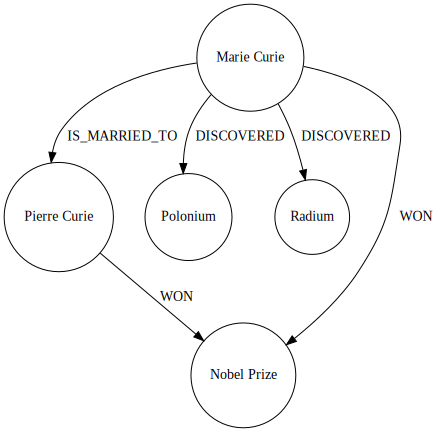

In [61]:
#| echo: true
from graphviz import Digraph

dot = Digraph()
for node in response.nodes:
    dot.node(str(node.id), node.label, shape='circle', width='1', height='1')
for edge in response.edges:
    dot.edge(str(edge.source), str(edge.target), label=edge.label.upper())

dot

# Conclusions

## Conclusions

- The goal is to provide better context to the LLM prior to generating its response
- Combining graph + vector retrieval help us to achieve this goal better than vector-only retrieval or graph-only retrieval
- Knowledge graph construction with structured outputs allows us to constrain the node types and edge types explicitly

## References

- [Enhancing the Accuracy of RAG Applications With Knowledge Graphs](https://neo4j.com/developer-blog/enhance-rag-knowledge-graph/) by Tomaž Bratanič
- [A GenAI-Powered Song Finder in Four Lines of Code](https://neo4j.com/developer-blog/genai-powered-song-finder/) by Christoffer Bergman
- [Graph RAG strategies using Kùzu](https://github.com/kuzudb/graph-rag) by Prashanth Rao
- [LanceDB](https://github.com/lancedb/lancedb) (vector DB) + [Kùzu](https://github.com/kuzudb/kuzu) (graph DB) +  [Llama.cpp](https://github.com/abetlen/llama-cpp-python) (inference) + [Outlines](https://dottxt-ai.github.io/outlines/) (structured outputs) + [LangChain](https://github.com/langchain-ai/langchain) (framework) + [Solara](https://github.com/widgetti/solara) (visualization)